# Rutgers Student Instructional Rating Survey (SIRS) Analysis

This project was started due to a combination of wanting to play with various python libraries and curiosity as to the results of the countless surveys that I took as a student.

The data was acquired using another python application (sirs_scraper in github) and most of the data processing was done outside this project. 

Initially, the data consisted of 1,742,798 rows (responses), with each question in each course survey getting its own row. The rows contain a count of ratings on a Likert scale of 1-5, with 1 being the 'worst' and 5 being the 'best'. A total of 202 questions were collected, however, we will only be focusing on the standard 'university' questions as they are consistent across almost all courses. 

A list of the questions used will be available in the apendix (bottom of page).

Final usable dataset is 1,703,467 rows by 23 columns with data from Spring 2001 to Spring 2016.

Below are some of the interesting results.

-response rate vs average ratings

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import linregress
import warnings
from sklearn import metrics
warnings.filterwarnings('ignore')

%matplotlib inline
#display floats with sci notation
#pd.options.display.float_format = '{:40,.4f}'.format

In [208]:
#sirs_master.txt is a tab delimited file that has already been merged from the courses, answers, and questions table.
master_df = pd.read_csv('sirs_master.csv', sep='\t', low_memory=False)
master_df.shape

(1703467, 23)

In [209]:
master_df.head(2)

,course_id,course_name,year,semester,school,department,course,section,regindex,instructor,...,response_rate,question_id,rating_1,rating_2,rating_3,rating_4,rating_5,blank,rating_average,question_text
0,1,Global Health,2015,Spring,45,705,652,1,11476.0,Lindgren Teri,...,0.9,1.0,0.0,0.0,0.0,1.0,8.0,0.0,4.888889,b'The instructor assigned grades fairly'
1,1,Global Health,2015,Spring,45,705,652,1,11476.0,Lindgren Teri,...,0.9,2.0,0.0,0.0,0.0,1.0,8.0,0.0,4.888889,b'The instructor was prepared for class and presented the material in an organized manner'


#### Some helper functions and setup

In [210]:
#import department id to names - note many departments no longer exist / were merged
#set column types so leading zero is not stripped
dtype_dic= {'department_id': str, 'department_name' : str}

departments_df = pd.read_csv('rutgers_departments.csv', sep=',', dtype=dtype_dic)

In [211]:
#helper functions
def get_department_correlations(data, x_val, y_val):
    #segments data by department and returns raw dictionary
    departments = data['department'].unique()
    department_correlations = []

    labels = ['department', 'correlation', 'p value', 'sample size']

    for department in departments:
        dept_df = data[data['department'] == department].groupby('course_id').mean()
        correlation = pearsonr(dept_df[x_val],dept_df[y_val])

        tmp = []
        tmp.append(department); # department id
        tmp.append(correlation[0]); #corr coef
        tmp.append(correlation[1]); #p value
        tmp.append(dept_df.shape[0])

        department_correlations.append(tmp)
        #error is due to divide by 0 
    return department_correlations

def get_department_correlation_df(data, cutoff = 50, sort_ascending = True, drop_na = True, dept_df = departments_df):
    #converts dictionary into dataframe, sorts and removes values lower than given cutoff
    
    labels = ['department', 'correlation', 'p value', 'sample size']
    dept_corr_df = pd.DataFrame.from_records(data, columns=labels)
    #drop nan values - those are departments who only use one form of data collection
    if drop_na == True:
        dept_corr_df.dropna(inplace=True)
    dept_corr_df = dept_corr_df[dept_corr_df['sample size'] > cutoff]
    dept_corr_df.sort_values(by="correlation",ascending=sort_ascending, inplace=True)
    dept_corr_df = dept_corr_df.join(dept_df.set_index('department_id'), on='department', how='left')
    
    return dept_corr_df

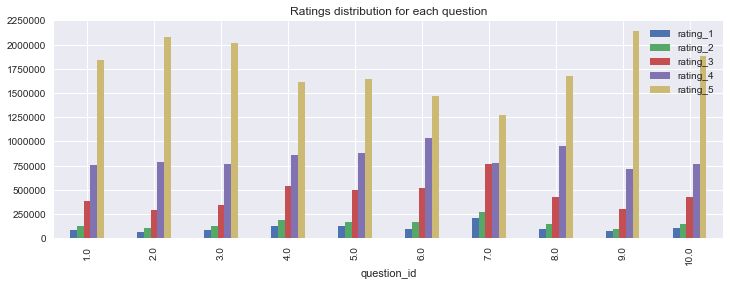

In [212]:
sdf_resp_avg_dist = master_df[
    ['year', 'source','department','course_id','question_id','response_rate','rating_1','rating_2','rating_3','rating_4','rating_5']
]
sdf_ratings_count = sdf_resp_avg_dist.groupby(['question_id']).sum()
sdf_rating_dist = sdf_ratings_count[['rating_1','rating_2','rating_3','rating_4','rating_5']]
sdf_rating_dist.plot(kind='bar',figsize=(12,4),title="Ratings distribution for each question")

## Analysis - Paper surveys vs. Online surveys

In the last few years at Rutgers, paper surveys are gradually being phased out in favor of online surveys. Switching to online data collection provides many benefits, ranging from convienence to cost/environment savings, as there is no longer a need to print out, process, and store hundreds of thousands of surveys every year.

But do these benefits come at a cost?

### Analysis - survey source vs ratings

We will first look to see if the method of survey collection influences overall ratings segmented by year or department.

In [213]:
survey_source_ratings_df = master_df[['rating_average', 'year', 'source', 'question_id','department','course_id','response_rate']]
#remove entries that do not have a year
survey_source_ratings_df = survey_source_ratings_df[survey_source_ratings_df['year'] > 0]

In [214]:
#rename eCollege surveys to online surveys as they are given online
survey_source_ratings_df.loc[survey_source_ratings_df['source'] == 'eCollege Survey', 'source'] = 'Online Survey'
#drop any rows that does not have 'Online Survey' or 'Scannable Paper Form'
survey_source_ratings_df = survey_source_ratings_df[survey_source_ratings_df['source'].isin(['Scannable Paper Form','Online Survey'])]
survey_source_ratings_df.head(2)

,rating_average,year,source,question_id,department,course_id,response_rate
0,4.888889,2015,Online Survey,1.0,705,1,0.9
1,4.888889,2015,Online Survey,2.0,705,1,0.9


In [215]:
#mean ratings of online vs paper over years
ssr_df_delta = survey_source_ratings_df.groupby(['year','source'])['rating_average'].agg([np.mean,np.size]).unstack()
ssr_df_delta.head(16)

mean                               size                     
source Online Survey Scannable Paper Form Online Survey Scannable Paper Form
year                                                                        
2001   NaN            4.188354            NaN            103090.0           
2002   NaN            4.205730            NaN            107050.0           
2003   NaN            4.225293            NaN            108859.0           
2004   NaN            4.240527            NaN            96989.0            
2005   NaN            4.265240            NaN            80574.0            
2006   NaN            4.301929            NaN            88244.0            
2007    3.820369      4.308391             30.0          66530.0            
2008    4.033371      4.344128             2384.0        90295.0            
2009    4.196379      4.372202             43529.0       60185.0            
2010    4.279983      4.413245             51181.0       23585.0            
2011    4.266293      4.344563             106380.0      21635.0            
2012    4.253526      4.339506             121034.0      18774.0            
2013    4.291293      4.389387             119995.0      17273.0            
2014    4.299595      4.398938             124694.0      21092.0            
2015    4.315136      4.444096             130104.0      23102.0            
2016    4.331708      4.468755             65680.0       11159.0

In [216]:
#separate mean and size
ssr_df_delta_avg = ssr_df_delta['mean']
ssr_df_delta_count = ssr_df_delta['size']

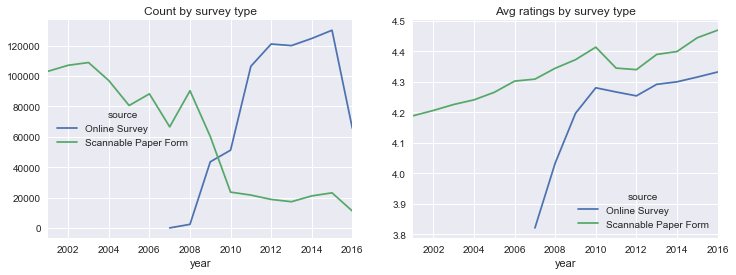

In [217]:
fig, axes = plt.subplots(nrows=1, ncols=2)

#count of responses by each survey type over the years
ssr_df_delta_count.plot(ax=axes[0],figsize=(12,4), title="Count by survey type")
#average ratings over the years separated by survey type
ssr_df_delta_avg.plot(ax=axes[1],figsize=(12,4), title="Avg ratings by survey type")

From this data, we can infer that online surveys started in 2007, though there is probably missing data from that year, as the total count for that year is much lower than the preceeding years. 

The first year of online surveys (2007) saw an average of 3.82, the lowest average for either survey type. This may be due to the students adjusting to a new system, or more likely, a small sample size.

In the survey type count graph, we can see paper forms lose popularity over the years while online is being rapidly adopted. Note that the drop in 2016 is due to missing data from Fall 2016.

In the ratings averages graph, we can see that the rating averages for online greatly increases from 2007 to 2010. Although rating averages for online never catches up to its paper counterpart, we can see that it generally follows the same trends with ups and downs. 

Interesting to note that in late 2009, online and paper surveys usage was about equal. The following year, 2010, the online rating averages started to follow the paper ratings trend. 

The graph may be slightly misleading due to scale, when the ratings level off, there is usually an under .15 difference in the ratings on a 1-5 scale.

Next, we will see if this difference is significant. 

In [218]:
#drop year 2001-2006 as they do not contain any online surveys
sdf_ratings_corr = survey_source_ratings_df[survey_source_ratings_df['year'] > 2006]
sdf_ratings_corr.head(2)

,rating_average,year,source,question_id,department,course_id,response_rate
0,4.888889,2015,Online Survey,1.0,705,1,0.9
1,4.888889,2015,Online Survey,2.0,705,1,0.9


In [219]:
#generate dummy variables
sdf_ratings_corr_grouped = pd.get_dummies(sdf_ratings_corr, columns=['source'])
sdf_ratings_corr_grouped.drop('source_Scannable Paper Form', axis=1, inplace=True)
#get average rating per course by grouping by course_id
sdf_ratings_corr_grouped = sdf_ratings_corr_grouped.groupby('course_id').mean()
#see correlation with total data set
pearsonr(sdf_ratings_corr_grouped['rating_average'],sdf_ratings_corr_grouped['source_Online Survey'])

(-0.073098620299413733, 1.7908764164905553e-132)

Now to calculate correlations at the department level.

In [220]:
sdf_ratings_dept = survey_source_ratings_df
#generate dummy variables
sdf_ratings_dept = pd.get_dummies(sdf_ratings_dept, columns=['source'])
sdf_ratings_dept.drop('source_Scannable Paper Form', axis=1, inplace=True)
sdf_ratings_dept.head()

,rating_average,year,question_id,department,course_id,response_rate,source_Online Survey
0,4.888889,2015,1.0,705,1,0.9,1
1,4.888889,2015,2.0,705,1,0.9,1
2,5.000000,2015,3.0,705,1,0.9,1
3,4.777778,2015,4.0,705,1,0.9,1
4,5.000000,2015,5.0,705,1,0.9,1


In [221]:
sdf_type_avg_dept_corr = get_department_correlations(sdf_ratings_dept,'rating_average','source_Online Survey')
sdf_type_avg_dept_corr_df = get_department_correlation_df(sdf_type_avg_dept_corr)
sdf_type_avg_dept_corr_df.head(4)

,department,correlation,p value,sample size,department_name
134,203,-0.508893,1.531697e-31,458,Dance
213,489,-0.406101,1.636725e-06,130,"Greek, Modern"
27,117,-0.327087,2.112655e-03,86,BIOENVIRONMENTAL ENGINEERING
164,290,-0.274560,4.886286e-02,52,NaN


In [222]:
sdf_type_avg_dept_corr_df.tail(4)

,department,correlation,p value,sample size,department_name
209,250,0.311143,9.804918e-03,68,NaN
7,725,0.322150,5.113370e-19,727,Pharmacy Practice and Admin
13,718,0.328561,2.200311e-04,122,PHARMACOLOGY AND TOXICOLOGY
11,721,0.354524,3.668533e-04,97,PHARMACEUTICS


### Results - ratings vs survey type

Initially, the correlation between the data source and ratings calculated as a whole, meaning all the relevant course data was included. This resulted in a correlation coefficient (r) of -0.0731 with a near zero probability value (p) < .0001. Due to the low coefficient, we probably cannot conclude any significant associations between average ratings and survey type when looking at the data as a whole.

Recognizing that each department is unique, we looked at the correlation segmented by the department. Departments with fewer than 50 courses were dropped due to low sample size, removing recently formed departments, now defunct departments, and relatively inactive departments.

There are numerous negative moderate correlations such as "Greek, Modern" as well as "Dance". With a p value of < .0001 and -0.5089 correlation coefficient, it appears that there is a moderate negative correlation between ratings and survey type, with online surveys having a negative impact on ratings.

There are also a few departments with a weak positive correlation, where the courses with online surveys tend to have higher ratings. Interestingly, the top 3 positive correlations are all pharma related.

<sup>The full output for department correlations will be provided in appendix</sup>

<hr/>

### Analysis - survey source vs response rate

Next, we will see if there is a correlation between survey source and response rate. 

In [223]:
sdf_resp = survey_source_ratings_df[['year', 'source','department','course_id','response_rate']]
#generate dummy variables
sdf_resp = pd.get_dummies(sdf_resp, columns=['source'])
sdf_resp.drop('source_Scannable Paper Form', axis=1, inplace=True)
sdf_resp = sdf_resp.groupby('course_id').mean()
sdf_resp.dropna(inplace=True)
sdf_resp.head(2)

,year,response_rate,source_Online Survey
course_id,,,
1,2015,0.9,1
10,2015,0.5,1


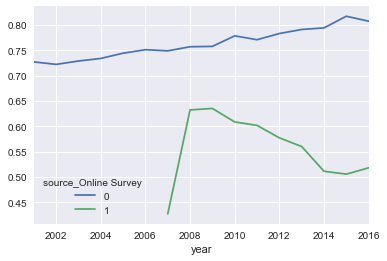

In [224]:
sdf_delta_response = sdf_resp.groupby(['year','source_Online Survey'])['response_rate'].mean().unstack()
sdf_delta_response.plot()

In [225]:
#drop data before 2006 as there are no online surveys
sdf_resp_corr = sdf_resp[sdf_resp['year'] > 2006]
pearsonr(sdf_resp_corr['response_rate'],sdf_resp_corr['source_Online Survey'])

(-0.45480676799315001, 0.0)

### Results - response rate vs survey type

Just from the graph, we can see that the yearly response rate for online is always lower than paper surveys. In fact, after 2009, the response rate for online surveys start to decline, while paper surveys increase. Once again, we see 2009-2010 as a period of interest, where the data takes on a new trend (not sure why though). 

There is also a moderate negative correlation of -0.455 between response rate and online surveys. One possible reason is because paper surveys are in practice almost always done during class time, so the students have already budgeted that time towards class related activities and in many cases, are an captive audience. The student is faced with a few choices: 

1. Fill out the survey and hand it in
2. Hand in a blank survey
3. Leave survey on desk and leave the class

In most cases, the student would choose 1 - fill out the survey and hand it in because there is very little effort or resistance involved. For classes with participation grades, there would be a high response rate, as most students will be present.

This is in contrast to online surveys, which have numerous possible obstacles
- technical issues
- require student to fill out in their own time 
- may forget (despite all the reminders)
- perception that it is not truly anonymous, as your identifiying data is briefly stored

To overcome these issues, I've seen many non-tenured or non-professional (has full-time job, teaches part-time) instructors reminding students multiple times throughout the semester to fill out the surveys. I've also seen some creative ways to increase response rate, ranging from candy for the class to increasing everyone's grade by a point if a certain percentage is reached (usually 85-90%). 

This practice is not uncommon and possibily skews the data significantly.

Survey response rates seem to be used in evaluating instructor performance, and is weighed in the tenure process as well as rehiring of part-time lecturers. Having a low response rate will not only look bad, but will impact the signifigance of the survey, due to a low sample size. Departments and instructors should take note of this correlation when looking at the survey results (not to be mistaken as causation). 
<hr/>


## Analysis response rate vs average rating

Is there a correlation between response rate and averate rating?

In [226]:
sdf_resp_avg_corr = survey_source_ratings_df[['year', 'source','department','course_id','response_rate','rating_average']]
#generate dummy variables
sdf_resp_avg_corr = pd.get_dummies(sdf_resp_avg_corr, columns=['source'])
sdf_resp_avg_corr.drop('source_Scannable Paper Form', axis=1, inplace=True)
sdf_resp_avg_corr.dropna(inplace=True)
sdf_resp_avg_corr.head(2)

,year,department,course_id,response_rate,rating_average,source_Online Survey
0,2015,705,1,0.9,4.888889,1
1,2015,705,1,0.9,4.888889,1


In [227]:
sdf_resp_avg_dept_corr = get_department_correlations(sdf_resp_avg_corr,'response_rate','rating_average')
sdf_resp_avg_dept_corr_df = get_department_correlation_df(sdf_resp_avg_dept_corr, drop_na=False)
sdf_resp_avg_dept_corr_df.head(6)

,department,correlation,p value,sample size,department_name
264,88,-0.256626,0.066290,52,Theater Television and Media Arts
11,721,-0.241408,0.041064,72,PHARMACEUTICS
127,632,-0.239306,0.031425,81,Filmmaking
37,963,-0.205597,0.115041,60,Toxicology
61,681,-0.187158,0.051329,109,Micromolecular Genetics
262,87,-0.179104,0.103074,84,Music Performance


In [228]:
sdf_resp_avg_dept_corr_df.tail(4)

,department,correlation,p value,sample size,department_name
234,146,0.304183,5.483252e-10,399,Cell Biology and Neuroscience
66,332,0.318253,3.078623e-37,1525,Electrical and Computer Engineering
193,516,0.352808,3.408113e-03,67,History - Camden
209,489,0.465475,8.468009e-08,120,"Greek, Modern"


In [229]:
#get correlation with whole data set
sdf_resp_avg_corr = sdf_resp_avg_corr.groupby('course_id').mean()
pearsonr(sdf_resp_avg_corr['response_rate'],sdf_resp_avg_corr['rating_average'])

(0.14798185915338719, 0.0)

### Results - response rate vs average rating

As a whole there is a weak positive correlation of .148 between response rate and average rating. Due to the weak correlation, we once again segmented the data by department and found that some departments such as 'Greek, Modern' have a higher (moderate) correlation of .465. Conversely, there are departments with a negative correlation between response rate and average rating, though many of them have a p value > .05, so it is not significant. 

<hr/>

# Analysis - correlation between questions

Below are the list of questions:

In [230]:
pd.set_option('display.max_colwidth', -1)
question_df = master_df[['question_id','question_text']].drop_duplicates()
question_df.head(10)

,question_id,question_text
0,1.0,b'The instructor assigned grades fairly'
1,2.0,b'The instructor was prepared for class and presented the material in an organized manner'
2,3.0,b'The instructor responded effectively to student comments and questions'
3,4.0,b'The instructional methods encouraged student learning'
4,5.0,b'I learned a great deal in this course'
5,6.0,b'I rate the overall quality of the course as'
6,7.0,b'I had a strong prior interest in the subject matter and wanted to take this course'
7,8.0,b'I rate the teaching effectiveness of the instructor as'
8,9.0,b'The instructor had a positive attitude toward assisting all students in understanding course material'
9,10.0,b'The instructor generated interest in the course material'


In [231]:
sdf_resp_avg_dist_corr = survey_source_ratings_df[['course_id','question_id','rating_average']]
sdf_rating_dist = sdf_resp_avg_dist_corr.groupby(['course_id','question_id']).mean().unstack()
sdf_rating_dist.corr()

rating_average                                \
question_id                           1.0       2.0       3.0       4.0   
               question_id                                                
rating_average 1.0          1.000000       0.680005  0.764738  0.792389   
               2.0          0.680005       1.000000  0.837411  0.815835   
               3.0          0.764738       0.837411  1.000000  0.874356   
               4.0          0.792389       0.815835  0.874356  1.000000   
               5.0          0.725334       0.780820  0.807675  0.889525   
               6.0          0.760612       0.795253  0.834214  0.901329   
               7.0          0.466008       0.380651  0.446696  0.526064   
               8.0          0.770994       0.851081  0.892868  0.923122   
               9.0          0.783714       0.769147  0.899948  0.850014   
               10.0         0.731329       0.787790  0.855007  0.906122   

                                                                              \
question_id                      5.0       6.0       7.0       8.0       9.0   
               question_id                                                     
rating_average 1.0          0.725334  0.760612  0.466008  0.770994  0.783714   
               2.0          0.780820  0.795253  0.380651  0.851081  0.769147   
               3.0          0.807675  0.834214  0.446696  0.892868  0.899948   
               4.0          0.889525  0.901329  0.526064  0.923122  0.850014   
               5.0          1.000000  0.904148  0.588545  0.865191  0.768693   
               6.0          0.904148  1.000000  0.586492  0.917327  0.794156   
               7.0          0.588545  0.586492  1.000000  0.463883  0.427398   
               8.0          0.865191  0.917327  0.463883  1.000000  0.849050   
               9.0          0.768693  0.794156  0.427398  0.849050  1.000000   
               10.0         0.865092  0.869061  0.535496  0.879555  0.826312   

                                      
question_id                     10.0  
               question_id            
rating_average 1.0          0.731329  
               2.0          0.787790  
               3.0          0.855007  
               4.0          0.906122  
               5.0          0.865092  
               6.0          0.869061  
               7.0          0.535496  
               8.0          0.879555  
               9.0          0.826312  
               10.0         1.000000

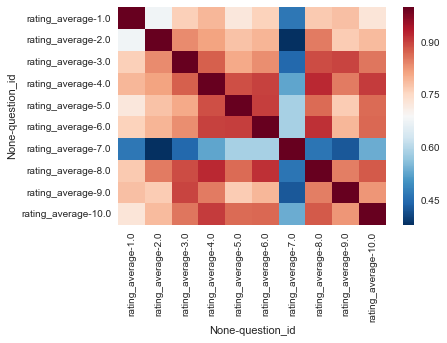

In [232]:
sns.heatmap(sdf_rating_dist.corr(), cmap='RdBu_r')

### Results - correlation between questions

One thing that stands out in the heatmap above is the lower (relative to others) correlations with question 7:
- "I had a strong prior interest in the subject matter and wanted to take this course" 

This makes sense, as we do not expect prior interest in the course to be correlated as much with questions pertaining to course pedagogy, such as instructor prepraration (question 2) or the instructor's attitude (question 9). The most correlated questions (with question 7) at .589 are:
- question 5 "I learned a great deal in this course"
- question 6 "I rate the overall quality of the course as"

Once again, this makes sense. Student interest has been shown to be a powerful force in positive learning outcomes. An engaged and motivated student tends to get more and learn more from the course. In my experience, instructors from both academia and industry are constantly looking for new ways to generate interest in their students. However, this may not always be possible due to a large number of courses being graduation requirements or mandatory training.


## Multiple Linear regression

We are interested in question 6 - 'I rate the overall quality of the course as' and will come up with a model to predict the 'overall quality of the course' using ratings from the other 9 questions.

In [233]:
sdf_resp_avg_dist_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1703447 entries, 0 to 1703466
Data columns (total 3 columns):
course_id         object
question_id       float64
rating_average    float64
dtypes: float64(2), object(1)
memory usage: 52.0+ MB


In [234]:
sdf_course_question_avg = sdf_resp_avg_dist_corr.groupby(['course_id','question_id']).mean().unstack()
sdf_course_question_avg.dropna(inplace=True)
sdf_course_question_avg.head()

rating_average                                                    \
question_id            1.0       2.0       3.0       4.0       5.0       6.0   
course_id                                                                      
1            4.888889       4.888889  5.000000  4.777778  5.000000  4.888889   
10           4.500000       4.700000  4.800000  4.500000  4.600000  4.500000   
100          5.000000       5.000000  5.000000  5.000000  5.000000  5.000000   
10000        4.105263       4.833333  4.666667  4.631579  4.473684  4.473684   
100000       4.224490       4.306122  4.000000  4.183673  4.408163  4.255319   

                                                     
question_id       7.0       8.0       9.0      10.0  
course_id                                            
1            4.444444  4.777778  5.000000  5.000000  
10           4.000000  4.500000  4.800000  4.700000  
100          4.333333  5.000000  5.000000  5.000000  
10000        3.294118  4.631579  4.842105  4.777778  
100000       4.142857  4.204082  4.224490  4.428571

In [235]:
sdf_lin_model = pd.DataFrame(sdf_course_question_avg.to_records())
#rename column names because I am bad
sdf_lin_model.rename(columns={"('rating_average', 1.0)": '1',"('rating_average', 2.0)": '2',"('rating_average', 3.0)": '3',"('rating_average', 4.0)": '4',
                  "('rating_average', 5.0)": '5',"('rating_average', 6.0)": '6',"('rating_average', 7.0)": '7',"('rating_average', 8.0)": '8',
                  "('rating_average', 9.0)": '9',"('rating_average', 10.0)": '10'}, inplace=True)
sdf_lin_model['course_id'] = sdf_lin_model.course_id.astype(int)
sdf_lin_model.sort_values(by='course_id', inplace=True, ascending=True)
sdf_lin_model.head()

,course_id,1,2,3,4,5,6,7,8,9,10
0,1,4.888889,4.888889,5.00,4.777778,5.000000,4.888889,4.444444,4.777778,5.000000,5.000000
81915,2,4.720000,4.840000,4.80,4.720000,4.640000,4.541667,4.040000,4.680000,4.680000,4.760000
92967,3,4.611111,4.388889,4.50,4.277778,4.222222,4.200000,3.833333,4.222222,4.611111,4.411765
103752,4,4.840000,4.840000,4.88,4.880000,4.800000,4.880000,4.375000,4.880000,4.880000,4.880000
114826,5,4.650000,4.450000,4.40,4.150000,4.150000,4.300000,3.894737,4.200000,4.500000,4.200000


In [236]:
x = sdf_lin_model[[1,2,3,4,5,7,8,9,10]]
y = sdf_lin_model[[6]]

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88)
lm = LinearRegression()
lm.fit(X = x_train.values,y = y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [238]:
#import statsmodels.api as sm
#model = sm.OLS(y, x).fit() ## sm.OLS(output, input)
#predictions = model.predict(x_test)
#model.summary()

In [239]:
coeff_df = pd.DataFrame(lm.coef_[0],x.columns,columns=['Coefficient'])
coeff_df

,Coefficient
1,0.061360
2,0.001336
3,-0.026274
4,0.070963
5,0.300786
7,0.100966
8,0.507830
9,-0.054634
10,0.057693


Coefficients:

In this model, most of the questions have fairly low correlation, with the exception of question 5 and 8.

- Question 5: 'I learned a great deal in this course'
- Question 8: 'I rate the teaching effectiveness of the instructor as'

This shows that the teaching effectiveness of the instructor and what the student learns from the course is associated with higher overall quality of the course. Though I suspect there is some level of interaction between all of these questions.

In [240]:
predictions = lm.predict(x_test)

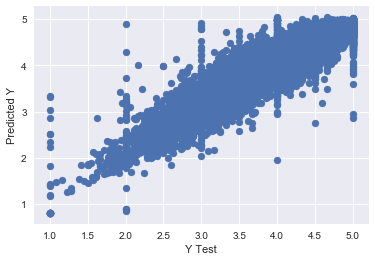

In [241]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

### Model evaluation

In [242]:
print('MAE - average error:', metrics.mean_absolute_error(y_test, predictions))
print('MSE - punishes larger errors:', metrics.mean_squared_error(y_test, predictions))
print('RMSE - punishes larger errors even more (also in Y - score units):', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('r^2:', metrics.r2_score(y_test,predictions))

MAE - average error: 0.126667067225
MSE - punishes larger errors: 0.0341775371182
RMSE - punishes larger errors even more (also in Y - score units): 0.184871677436
r^2: 0.901902359063


</hr>

## New data - Fall 2016

Data for Fall 2016 was recently released. Below we will load it and see how our model tests against it.

In [243]:
#new fall 2016 data
sirs_f2016_df = pd.read_csv('sirs_f_2016.csv', sep='\t', low_memory=False)
sirs_f2016_df.shape

(81990, 23)

In [244]:
sirs_f2016_df['source'].unique()

array(['Sakai Survey', 'Scannable Paper Form', 'evaluationKit Survey'], dtype=object)

In [245]:
sirs_f2016_df.groupby(['source'])['source'].count()

source
Sakai Survey            61246
Scannable Paper Form    12945
evaluationKit Survey    7799 
Name: source, dtype: int64

We see scannable paper form, which is the paper survey. However, they have replaced the "Online Survey" value with "Sakai Survey," which is more accurate, as most of the surveys conducted online prior were all done in Sakai. Also, eCollege survey was removed (due to the deprecation of the service) and replaced with evaluationKit Survey.

For our purposes, initial analysis will group "Sakai Survey" and "evaluationKit Survey" together as "Online Survey." Later, we will break them up later and look at them separately.

In [246]:
sirs_f2016_df.to_csv("sirs_f_2016.csv",sep="\t",index=False)

In [247]:
sdf_f2016_course_question_avg = sirs_f2016_df[['course_id','question_id','rating_average']]

In [248]:
sdf_f2016_avgs = sdf_f2016_course_question_avg.groupby(['course_id','question_id']).mean().unstack()
sdf_f2016_avgs.dropna(inplace=True)
sdf_f2016_avgs.head()

rating_average                                                    \
question_id              1         2         3         4         5         6   
course_id                                                                      
171848       4.666667       4.666667  4.666667  4.555556  4.777778  4.444444   
171849       4.153846       4.583333  4.384615  3.923077  4.076923  4.076923   
171850       4.592593       4.777778  4.629630  4.777778  4.592593  4.555556   
171851       4.166667       4.000000  3.833333  3.500000  3.500000  3.666667   
171852       4.909091       4.909091  4.818182  4.818182  4.800000  4.727273   

                                                     
question_id         7         8         9        10  
course_id                                            
171848       4.333333  4.375000  4.777778  4.888889  
171849       3.000000  4.000000  4.307692  4.230769  
171850       3.961538  4.629630  4.740741  4.740741  
171851       3.166667  3.833333  3.833333  4.000000  
171852       3.818182  4.818182  4.909091  4.727273

In [249]:
sdf_f2016_lin_model = pd.DataFrame(sdf_f2016_avgs.to_records())
sdf_f2016_lin_model.rename(columns={"('rating_average', 1)": '1',"('rating_average', 2)": '2',"('rating_average', 3)": '3',"('rating_average', 4)": '4',
                  "('rating_average', 5)": '5',"('rating_average', 6)": '6',"('rating_average', 7)": '7',"('rating_average', 8)": '8',
                  "('rating_average', 9)": '9',"('rating_average', 10)": '10'}, inplace=True)
sdf_f2016_lin_model['course_id'] = sdf_lin_model.course_id.astype(int)
sdf_f2016_lin_model.sort_values(by='course_id', inplace=True, ascending=True)
sdf_f2016_lin_model.head()

,course_id,1,2,3,4,5,6,7,8,9,10
0,1,4.666667,4.666667,4.666667,4.555556,4.777778,4.444444,4.333333,4.37500,4.777778,4.888889
1,10,4.153846,4.583333,4.384615,3.923077,4.076923,4.076923,3.000000,4.00000,4.307692,4.230769
2,100,4.592593,4.777778,4.629630,4.777778,4.592593,4.555556,3.961538,4.62963,4.740741,4.740741
1102,101,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.750000,5.00000,5.000000,5.000000
2194,102,4.833333,4.833333,4.666667,4.833333,4.833333,4.666667,4.833333,4.50000,4.833333,4.833333


In [250]:
x_2016 = sdf_f2016_lin_model[[1,2,3,4,5,7,8,9,10]]
y_2016 = sdf_f2016_lin_model[[6]]

In [251]:
predictions_fall_2016 = lm.predict(x_2016)

In [252]:
#fall 2016 model eval
print('MAE - average error:', metrics.mean_absolute_error(y_2016, predictions_fall_2016))
print('MSE - punishes larger errors:', metrics.mean_squared_error(y_2016, predictions_fall_2016))
print('RMSE - punishes larger errors even more (also in Y - score units):', np.sqrt(metrics.mean_squared_error(y_2016, predictions_fall_2016)))
print('r^2:', metrics.r2_score(y_2016,predictions_fall_2016))

MAE - average error: 0.131571096595
MSE - punishes larger errors: 0.0377505791174
RMSE - punishes larger errors even more (also in Y - score units): 0.194295082587
r^2: 0.896940962663


## Conclusion - work in progress

We began with a data with about 1.7 million rows by 23 columns, with each row representing aggregate ratings the 10 university wide questions. In all, this initial dataset represents the responses of 3,411,720 students from 2001 to Spring 2016.

First, we did some data analysis, showing that even if there was a weak correlation when looking at the entire data set, there were many stronger correlations when broken down by department.
//write about question correlations
//write about response rate vs average rating
//write about survey type vs average rating

Finally, we created a simple machine learning algorithm (linear regression) to create a model that attempts to predict the overall quality of the course given the other 9 questions. 

Recently, the data for Fall 2016 was released, with 81990 rows representing 130,367 responses in similar format to initial data set.

We took this Fall 2016 data set and ran it through our regression model and came up with similar outcomes as the initial training set, though the RMSE is slightly higher (F-2016: .194 vs Initial: .185) as well as r^2(F-2016: .897 vs Initial: .901). The RMSE measures errors in the dependent variable (Y value - overall quality of course - question 6), so a .194 in a 1-5 range can be considered fairly small.

Next steps:

Look into creating a model to predict overall course quality given only course information (course_name, school, department, course, enrolled, responses, year, semester)

See if we can improve the model - model, include survey type (online / paper) as well as response rate in model.

Note: I will not make the data sets public - but if you have a Rutgers account, you can easily view them at https://sirs.ctaar.rutgers.edu

<hr/>
### Appendix


In [253]:
pd.set_option('display.max_rows', 500)

In [254]:
#Response rate vs average rating
sdf_resp_avg_dept_corr_df

,department,correlation,p value,sample size,department_name
264,88,-0.256626,6.628996e-02,52,Theater Television and Media Arts
11,721,-0.241408,4.106365e-02,72,PHARMACEUTICS
127,632,-0.239306,3.142489e-02,81,Filmmaking
37,963,-0.205597,1.150406e-01,60,Toxicology
61,681,-0.187158,5.132926e-02,109,Micromolecular Genetics
262,87,-0.179104,1.030743e-01,84,Music Performance
13,718,-0.162449,7.503730e-02,121,PHARMACOLOGY AND TOXICOLOGY
301,990,-0.135726,3.096925e-01,58,Zoology
156,256,-0.119039,2.455073e-01,97,NaN
7,725,-0.114282,2.373912e-03,705,Pharmacy Practice and Admin


In [255]:
#Survey type (online/paper) vs average rating
sdf_type_avg_dept_corr_df

,department,correlation,p value,sample size,department_name
134,203,-0.508893,1.531697e-31,458,Dance
213,489,-0.406101,1.636725e-06,130,"Greek, Modern"
27,117,-0.327087,2.112655e-03,86,BIOENVIRONMENTAL ENGINEERING
164,290,-0.274560,4.886286e-02,52,NaN
201,989,-0.245728,9.145612e-04,179,WRITING
154,293,-0.245275,3.011631e-06,354,EDUCATION SPECIAL EDUCATION
120,140,-0.241240,7.256442e-04,193,BUSINESS LAW
196,964,-0.240140,5.291158e-07,426,TEACHER PREPARATION
165,297,-0.210459,1.536000e-03,224,EDUCATION-COUNSELING PSYCHOLOGY
15,155,-0.208312,1.530340e-05,424,CHEMICAL AND BIOCHEMICAL ENGINEERING
